<div style='background-image: url("../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Signal Processing</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Convolution - Solution</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Stefanie Donner ([@stefdonner](https://github.com/stefdonner))
* Celine Hadziioannou ([@hadzii](https://github.com/hadzii))
* Ceri Nunn ([@cerinunn](https://github.com/cerinunn))


---

<h1>Convolution</h1>
<br>

In [1]:
# Cell 0 - Preparation: load packages, set some basic options  
%matplotlib inline
from __future__ import print_function
from obspy import *
import numpy as np
from scipy import interpolate, signal
from time import *
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 3
plt.rcParams['lines.linewidth'] = 0.5

## Con ... what?

In seismology, very often we are dealing with *linear systems*. A linear system, in the most general sense, is a mathematical model based on a linear operator. Here, this operator is the *convolution*. The output signal of a linear system is the *convolution* of the input signal with the *impulse response* of the system. Examples of linear systems in seismology are:
   + seismometers - a physical linear system altering the recording signal
   + Green's functions - response of the Earth to an impulsive excitation
   + filter - mathematical linear systems
   + ...

Mathematically, the convoluton ($*$) is the weighted mean of the input signal $x(t)$ with $h(t)$ as the weighting, i.e. the superposition of $x(t)$ with a mirrored and shifted version of $h(t)$:  

$$ y(t) = h(t) * x(t) \equiv \int_{-\infty}^{\infty} x(\tau)h(t-\tau)d\tau \\ = \int_{-\infty}^{\infty} x(t-\tau)h(\tau)d\tau = x(t) * h(t) $$ 

$h(t)$ is called the *impulse response* of the system. It can also be called *convolution function* or *kernel*. Intuitively spoken, it is the *characteristic* of the system, the mathematical description of what the linear system is doing to the input signal.    


The equation for the *discrete convolution* is:   

$$ (x+h)[k] \equiv \sum_{i=0}^{m} x[i]h[k-i] \hspace{2cm} with $$ 

$$ x_i \hspace{1cm} i=0,1,2,...,m $$
$$ h_j \hspace{1cm} j=1,2,...,n $$
$$ k = 0,1,2,...,m+n-1 $$

You could also memorize the mathematical operation of convolution as:   

$$ \Longrightarrow  flip, shift, multiply\ and\ add $$

Nice and intuitive gif animations can be found e.g. [here](https://commons.wikimedia.org/wiki/File:Convolution_Animation_%28Gaussian%29.gif), [here](https://commons.wikimedia.org/wiki/File:Convolution_Animation_%28Boxcar_and_Ramp%29.gif), and [here](https://commons.wikimedia.org/wiki/File:Convolution_Animation_%28Boxcar%29.gif).

The convolution has several helpful properties:    
$\hspace{4cm}$ Commutative  $\hspace{4cm} x(t)*h(t)= h(t)*x(t)$    
$\hspace{4cm}$ Distributive  $\hspace{4.4cm} x(t) * [h(t)+g(t)] = [x(t)*h(t)]+[x(t)*g(t)] $    
$\hspace{4cm}$ Associative (with scalar)  $\hspace{2.25cm} a[x(t)*h(t)] = [ax(t)]*h(t)$      
$\hspace{4cm}$ Multiplicative identity  $\hspace{2.8cm} x(t) * \delta(t) = x(t) \hspace{0.5cm}$  and   $\hspace{0.5cm} x(t)*H(t) = \int x(t)dt $

The most important property is the *__convolution theorem__*:

$$ F\{x(t)*h(t)\} = F\{x(\omega)\} \cdot F\{h(\omega)\}   $$

Or in words:   
> __A convolution in the time-domain is a multiplication in the frequency-domain, and vice-verca.__

And there we are again, transfering our data from one domain into the other using the [*Fourier transformation*](fourier_transform.ipynb) with all its possible pitfals, such as Nyquist theorem and Gibb's phenomenon. Make sure that you are familiar with that topic as well.


---
### Convolving functions

The following cells are dedicated to the understanding of what the convolution does to the input signal. In cell 1, we define a function which takes a signal and an impulse response as input and provides us the convolution of both. In cell 2, we define a boxcar function, a Rieker wavelet, and a $\cos$ Signal, which we use to play around with in the cells 3 and 4.

1) In cell 3 (concolution of boxcar with Rieker wavelet), what to do you observe concerning the time needed for calculation? What do you observe concerning the number of samples of the original and convolved functions?   
2) In cell 4 (concolution of boxcar with $\cos$), compare the results of the two convolved signals and try to explain your observation. Why do the two convolved functions look different?      

In [2]:
# Cell 1 - define a convolution function
def conv(x, y):
    """Calculates the discrete convolution of two signals x and y.
    In
    ----------
    x : first signal, the "measurement" (array of floats)
    y : second signal, the convolution function, sometimes called kernel (array of float)
    
    Out
    -------
    c : convolution (array of floats)
    """
    m = len(x)
    n = len(y)
    c = np.zeros(m+n-1)              # initally, setting all convolution values to zero
    
    for i in range(0, m):
        for j in range(0, n):
            c[i] += x[i-j] * y[j]
            
    return c

number of samples of input signals: 4096


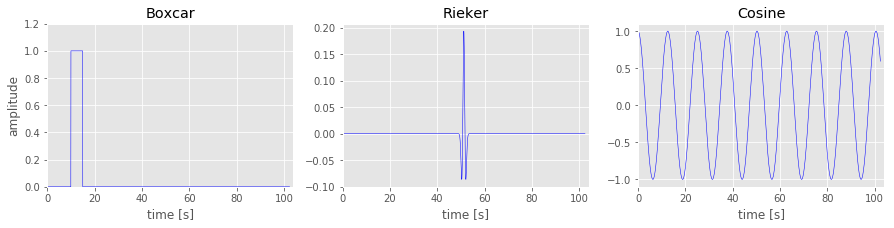

In [3]:
# Cell 2 - creating signals
npts = 4096                               # number of samples (initial: 4096)
dt = 0.025                                # sample rate (initial: 0.025) 
t = np.linspace(0,npts*dt,npts)           # time axis for plotting

box = np.zeros(npts)                      # boxcar function
for i in range(400,600):
    box[i] = 1.
rk = signal.ricker(npts, 20.0)            # Rieker wavelet, 2nd number = width of wavelet (intial: 20.0) 
cosine = np.cos(t/2)                      # cosine wavelet
print('number of samples of input signals:', npts)

# plot 
plt.rcParams['figure.figsize'] = 15, 3
xmax = 104                                # max. value for x-axis to zoom into (initial: 104)
plt.subplot(131)
plt.plot(t, box, 'b')
plt.ylim(0,1.2)
plt.xlim(0,xmax)
plt.xlabel('time [s]')
plt.title('Boxcar')
plt.ylabel('amplitude')

plt.subplot(132)
plt.plot(t, rk, 'b')
plt.xlim(0,xmax)
plt.title('Rieker')
plt.xlabel('time [s]')

plt.subplot(133)
plt.plot(t, cosine, 'b')
plt.title('Cosine')
plt.xlim(0,xmax)
plt.xlabel('time [s]')

plt.show()

In [4]:
# Cell 3 - convolve boxcar with Rieker
tick1 = time()                                             # measures time since 01.01.1970 in seconds
c1 = conv(rk, box)                                         # calculate convolution using function of cell 1
tick2 = time()                      

tick3 = time()
c2 = np.convolve(rk, box)                                  # calculate convolution using predefined function of numpy
tick4 = time()

delta1=tick2 - tick1                                       # taking first time difference and give it in seconds
print("1st run: %6.4f seconds needed for calculation"%delta1)
delta2=tick4 - tick3                                       # taking second time difference and give it in seconds
print("2nd run: %6.4f seconds needed for calculation"%delta2)

1st run: 6.7002 seconds needed for calculation
2nd run: 0.0034 seconds needed for calculation


number of samples of input signals: 4096
number of samples of convolved signal: 8191


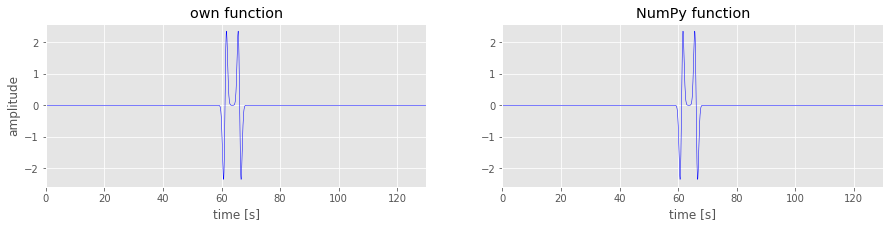

In [5]:
# Cell 3 - plot
print('number of samples of input signals:', npts)
print('number of samples of convolved signal:', len(c1))
npts2 = len(c1)
t2 = np.linspace(0,npts2*dt,npts2)

xmax = 130
plt.subplot(121)
plt.plot(t2, c1, 'b')
plt.xlim(0,xmax)
plt.xlabel('time [s]')
plt.title('own function')
plt.ylabel('amplitude')

plt.subplot(122)
plt.plot(t2, c2, 'b')
plt.xlim(0,xmax)
plt.title('NumPy function')
plt.xlabel('time [s]')

plt.show()

In [6]:
# Cell 4 - convolve boxcar with cosine
tick1 = time()                                            # measures time since 01.01.1970 in seconds
C1 = conv(cosine, box)                                    # calculate convolution using function of cell 1
tick2 = time()                     

tick3 = time()
C2 = np.convolve(cosine, box)                             # calculate convolution using predefined function of numpy
tick4 = time()

Delt1=tick2 - tick1                                       # taking first time difference and give it in seconds
print("1st run: %6.4f seconds needed for calculation"%Delt1)
Delt2=tick4 - tick3                                       # taking second time difference and give it in seconds
print("2nd run: %6.4f seconds needed for calculation"%Delt2)

1st run: 6.3025 seconds needed for calculation
2nd run: 0.0032 seconds needed for calculation


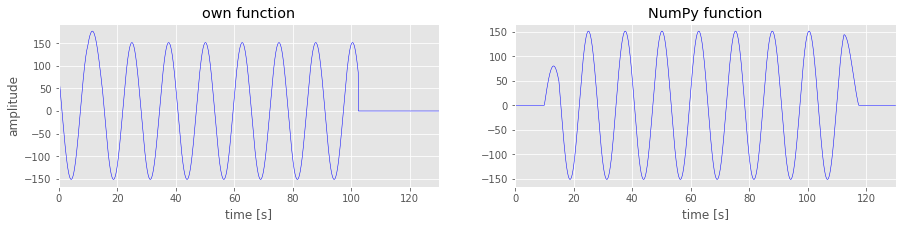

In [7]:
# Cell 4 - plot
NPTS2 = len(C1)
T2 = np.linspace(0,NPTS2*dt,NPTS2)

# plot
Xmax = 130
plt.subplot(121)
plt.plot(T2, C1, 'b')
plt.xlim(0,Xmax)
plt.xlabel('time [s]')
plt.title('own function')
plt.ylabel('amplitude')

plt.subplot(122)
plt.plot(T2, C2, 'b')
plt.xlim(0,Xmax)
plt.title('NumPy function')
plt.xlabel('time [s]')

plt.show()

---
#### Answers

1) The professionally implemented convolution function from the numpy package performs the convolution using FFT (Fast Fourier Transformation). Thus, it is much faster than the primitively implemented equation of the discrete convolution. Especially for large data (including a high number of samples) this is very important.    
The input signals all consist of 4096 samples. Combining them, we would expect 8192 samples. Instead the convolved signal only has 8191 samples, one sample less. This is inherited in the definition of the discrete convolution (see above) and very important to consider during digital data processing.  

2) The professional implemented convolution function of the numpy package includes correct pre-processing of the data, such as [tapering](spectral_analysis+preprocessing.ipynb) before convolution. The self-coded discrete convolution function of cell 1 does not. Because the first and last sample of the cosine function from cell 2 have different amplitudes, we obtain a wrong result, if we do not consider tapering. This is a consequence from the properties of the [Fourier transformation](fourier_transform.ipynb).   

<br>
<br>

---
### Convolving noisy data

This exercise will show you what happens to noisy data during convolution. This effect has severe consequences for [deconvolution](deconvolution.ipynb) (treated in a separate notebook).    
In cell 5, we first define a Gaussian signal and 'spoil' it with noise. Also, a fictive convolution function is defined. In cell 6, we then have a look on the convolution of the 'clean' and 'noisy' data with the convolution function.

3) Compare the two signals and the convolution function in cell 5. Can you explain them?   
4) Compare the convolution of both signals with the convolution function in cell 6. Describe what you see.   
5) Play around with the convolution in cell 6:
- Change the factors in the two lines where the convolution is done. Is the result the same? Why?  
- Multiply with a scalar; first to the signal before convolution, then only to the convolved signal. What happens?
- What happens if you add another fictive convolution function to the first one and then perform the convolution?

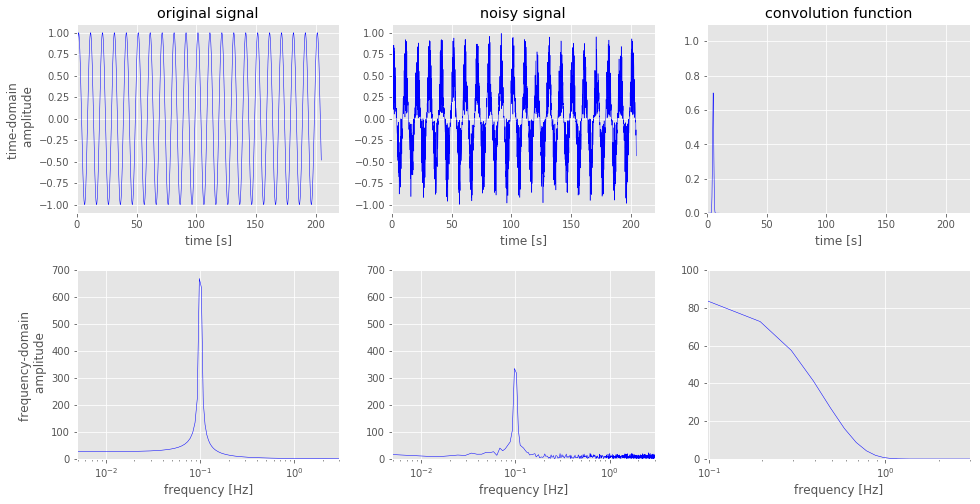

In [8]:
# Cell 5 - setting up a 'clean' and 'noisy' signal plus convolution function
samp = 2048                                                     # number of samples (initial: 2048)
rate = 0.1                                                      # sample rate (initial: 0.1) 
time = np.linspace(0, samp*rate, samp)                          # time axis of signals
sig = np.sin(2*np.pi*rate * time + np.pi/5)                     # clean sinusoid
nos = sig  * np.random.rand(sig.size)                           # adding noise to signal

taper_percentage = 0.03                                         # prepare taper
taper = np.bartlett(int(samp * taper_percentage))
taper_left, taper_right = np.array_split(taper, 2)              # fill middle part of taper with ones (fit data length)
taper = np.concatenate([taper_left, np.ones(samp-len(taper)), taper_right])

Sig = sig * taper                                               # taper the signals
Nos = nos * taper

samp2 = 1024                                                    # generate Gaussian convolution function
rate2 = 0.01
gauss = 0.7 * signal.gaussian(samp2, std=50)
tg = np.linspace(0, samp2*rate2, samp2)


# plot 
plt.rcParams["figure.figsize"] = (16, 8)
xmx = 220                                                       # max. value for x-axis to zoom in
ymm = 1.1                                                       # min./max. value for y-axis to zoom in
xfm = 3                                                         # max. value for x-axis in frequency-domain
yfm = 700                                                       # max. value for y-axis in frequency-domain

plt.subplot(231)
plt.plot(time, sig, 'b')
plt.title('original signal')
plt.xlim(0, xmx)
plt.ylim(-ymm, ymm)
plt.xlabel('time [s]')
plt.ylabel('time-domain \n amplitude')

plt.subplot(232)
plt.plot(time, nos, 'b')
plt.xlim(0, xmx)
plt.ylim(-ymm, ymm)
plt.title('noisy signal')
plt.xlabel('time [s]')

plt.subplot(233)
plt.plot(tg, gauss, 'b')
plt.xlim(0, xmx)
plt.ylim(0, ymm)
plt.title('convolution function')
plt.xlabel('time [s]')

plt.subplot(234)
Fsig = np.fft.rfft(sig)                                         # calculate FFT of clean signal 
f = np.linspace(0, (1/rate)/2, len(Fsig))                       # get frequency-domain x-axis for plotting
plt.semilogx(f, abs(Fsig), 'b')
plt.xlim(0,xfm)
plt.ylim(0,yfm)
plt.xlabel('frequency [Hz]')
plt.ylabel('frequency-domain \n amplitude')

plt.subplot(235)
Fnos = np.fft.rfft(nos)                                         # calculate FFT of noisy signal
plt.semilogx(f, abs(Fnos), 'b')
plt.xlim(0,xfm)
plt.ylim(0,yfm)
plt.xlabel('frequency [Hz]')

plt.subplot(236)
GAUSS = np.fft.rfft(gauss)                                      # calculate FFT of convolution function
fg = np.linspace(0, (1/rate2)/2, len(GAUSS))
plt.semilogx(fg, abs(GAUSS), 'b')
plt.xlim(0,xfm)
plt.ylim(0,yfm/7)
plt.xlabel('frequency [Hz]')

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

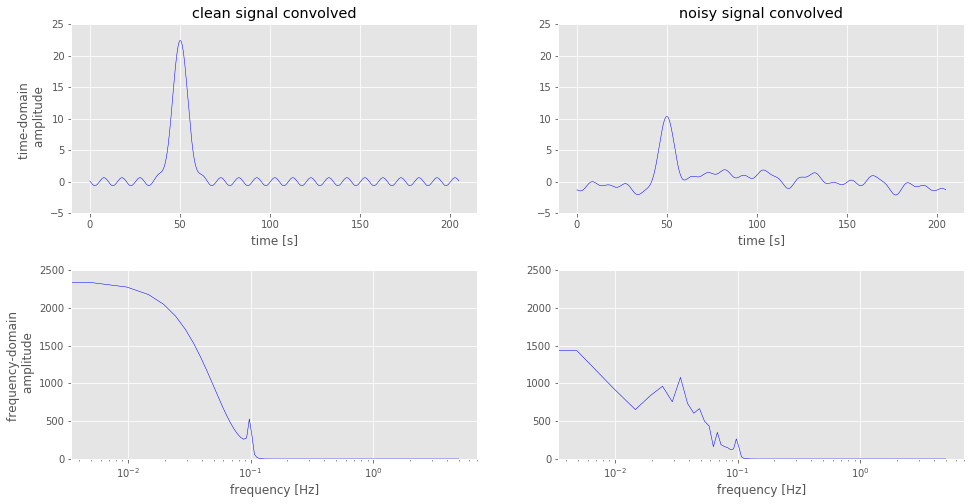

In [9]:
# Cell 6 - convolve both signals with "characteristic"

padding_factor = samp/samp2                     # zero padding to ensure that G has the same length than the functions
G = np.fft.rfft(gauss, n=int(len(gauss)*padding_factor))        # FFT of zero-padded gaussian
Sconv = np.fft.irfft(G * Fsig)                                  # convolve pure signal
Nconv = np.fft.irfft(G * Fnos)                                  # convolve noisy signal

# plot 
tc = np.linspace(0, len(Nconv)*rate, len(Nconv))                # time axis
plt.rcParams["figure.figsize"] = (16, 8)
ymin = -5
ymax = 25
fym = 2500

plt.subplot(221)
plt.plot(tc, Sconv, 'b')
plt.ylim(ymin,ymax)
plt.title('clean signal convolved')
plt.xlabel('time [s]')
plt.ylabel('time-domain \n amplitude')

plt.subplot(222)
plt.plot(tc, Nconv, 'b')
plt.ylim(ymin,ymax)
plt.title('noisy signal convolved')
plt.xlabel('time [s]')

plt.subplot(223)
SC = np.fft.rfft(Sconv)
fac = np.linspace(0, (1/rate)/2, len(SC))
plt.semilogx(fac, abs(SC), 'b')
plt.ylim(0,fym)
plt.xlabel('frequency [Hz]')
plt.ylabel('frequency-domain \n amplitude')

plt.subplot(224)
NC = np.fft.rfft(Nconv)
plt.ylim(0,fym)
plt.semilogx(fac, abs(NC), 'b')
plt.xlabel('frequency [Hz]')

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

---
#### Answers

3) The original signal is a really pure and clean signal. Not only in the time-domain but also in the frequency-domain the amplitude spectra shows a distinct peak with a maximum amplitude of almost 700. This spectrum tells us that we have a signal what is constructed from only one single frequency.   
In contradiction, the noisy signal in time-domain looks ... noisy. We can still recognise the dominating sinusoid but the min./max. amplitudes are biased and we can see further contributions to the signal. These further constributions are even more clear in the amplitude spectrum of the noisy signal. We see frequency contributions higher and lower than the dominating 1 Hz of the sinusoid. Therefore, the max. amplitude is much smaller than before because the remaining amplitude is 'distributed' in the noise.    
Our linear system is characterised by a simple Gaussian in the time-domain with its peak amplitude at about 5 seconds and a much smaller amplitude than the signals. The amplitude spectrum of this Gaussian - its Fourier transformation - is again a Gaussian with a much broader width. This is due to the [uncertainty principle](spectral_analysis+preprocessing.ipynb), another effect of the properties of the [Fourier transform](fourier_transform.ipynb).   

4) The convolution result of the clean signal is very nice again. In the frequency domain, we can clearly distinguish the contribution of the signal and the convolution function. The convolution result of the noisy data is clearly distorted by the noise. In the time-domain, we can still distinguish the peak of the convolution function, but in the frequency domain everything is blurred. We can still see the peak at 0.1Hz but only because we know that there must be a peak. If it would be real data, we cannot be sure, if this is real or an artefact of noise.   

5) When done correctly, all these experiments shall give you the same convolution result. See again the properties of the convolution in the theory part.